# Summer School - Modeling Water Fluxes In The Soil-Plant System

## Soil hydraulics with Dumux-rosi

In [2]:
import os
#sourcedir = os.getcwd()+"/../../../"
sourcedir = "/opt/dumux/CPlantBox/"
import sys;  
sys.path.append(sourcedir+"../dumux-rosi/python/modules");
sys.path.append(sourcedir+"../dumux-rosi/build-cmake/cpp/python_binding/");
sys.path.append(sourcedir)  
sys.path.append(sourcedir+"src")  
import matplotlib.pyplot as plt  
import numpy as np  
 
import plantbox as pb
import visualisation.vtk_plot as vp # for quick vizualisations
from rosi_richards import RichardsSPnum  # C++ part (Dumux binding)
from rosi_richards import RichardsSP
from richards import RichardsWrapper  # Python part  
from rosi_richards_cyl import RichardsCylFoam  # C++ part (Dumux binding), macroscopic soil model
from richards_flat import RichardsFlatWrapper  # Python part of cylindrical
import functional.van_genuchten as vg

### Size and Resolution of the domain

Computed bounding box tree with 249 nodes for 125 grid entities in 5.4966e-05 seconds.
Computed bounding box tree with 249 nodes for 125 grid entities in 2.9568e-05 seconds.
 -- Using the default temperature of 293.15 in the entire domain. Overload temperatureAtPos() in your spatial params class to define a custom temperature field.Or provide the preferred domain temperature via the SpatialParams.Temperature parameter.


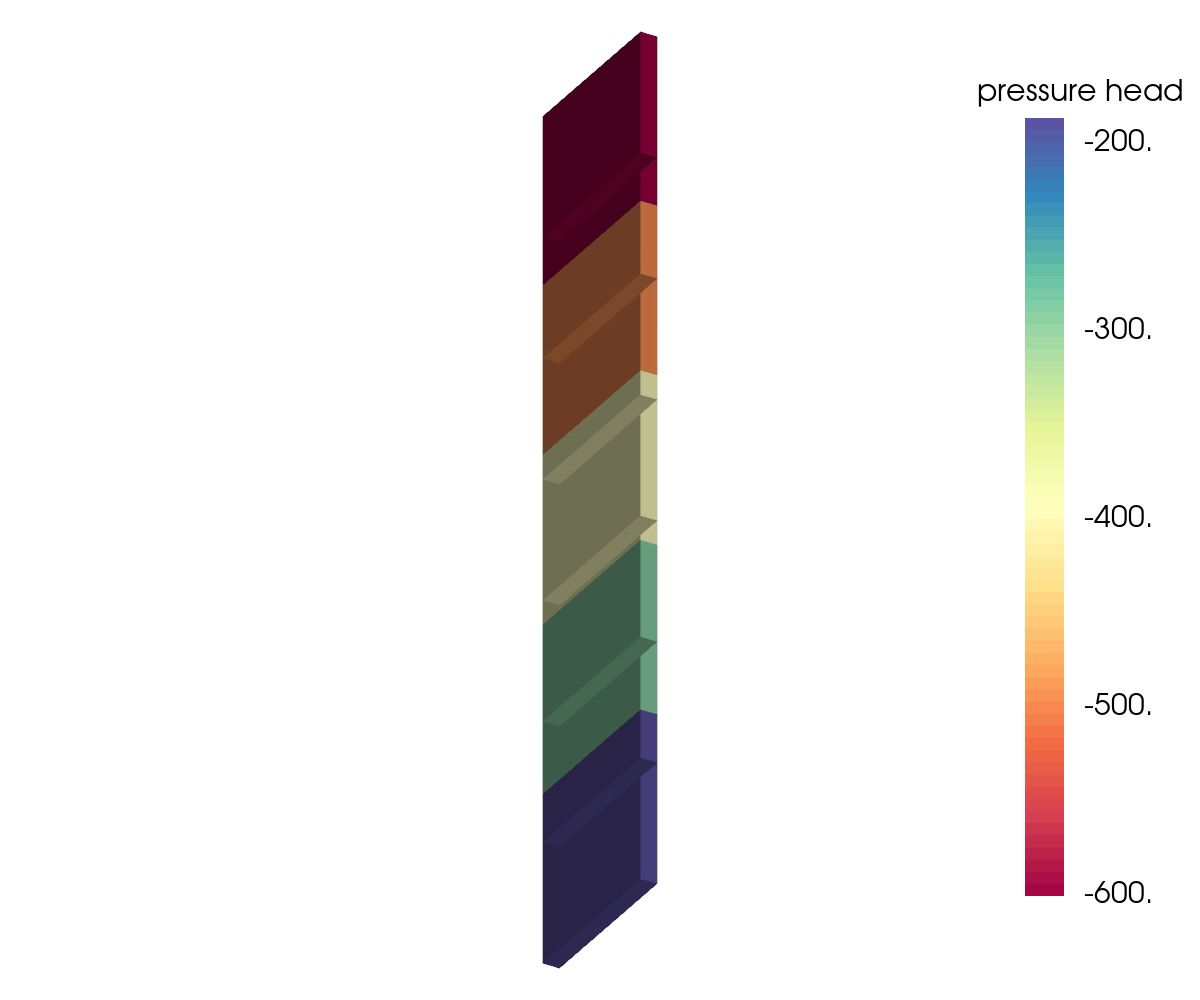

Computed bounding box tree with 249999 nodes for 125000 grid entities in 0.0449939 seconds.
Computed bounding box tree with 249999 nodes for 125000 grid entities in 0.0418838 seconds.


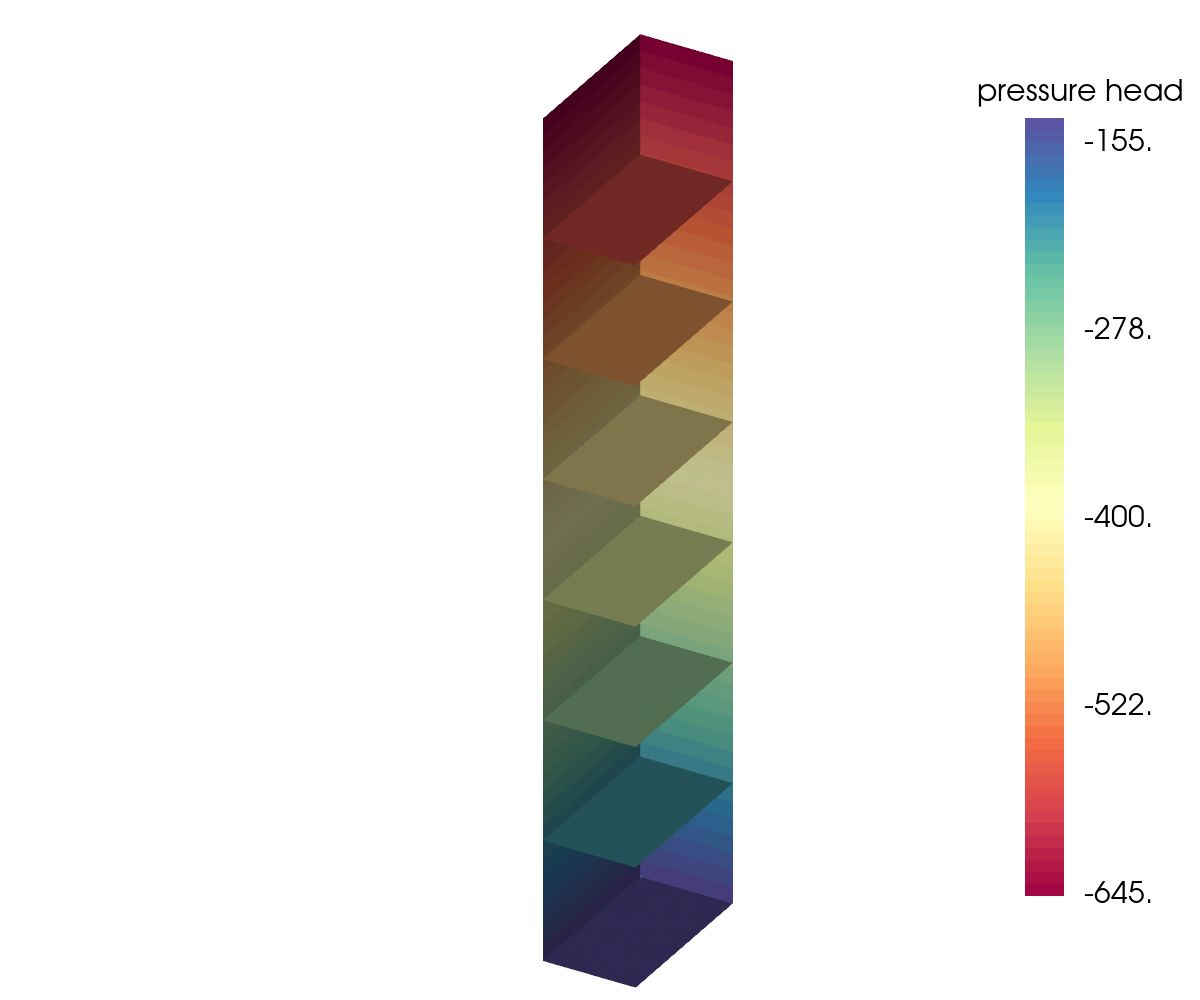

Computed bounding box tree with 99 nodes for 50 grid entities in 3.7488e-05 seconds.
Computed bounding box tree with 99 nodes for 50 grid entities in 1.5664e-05 seconds.


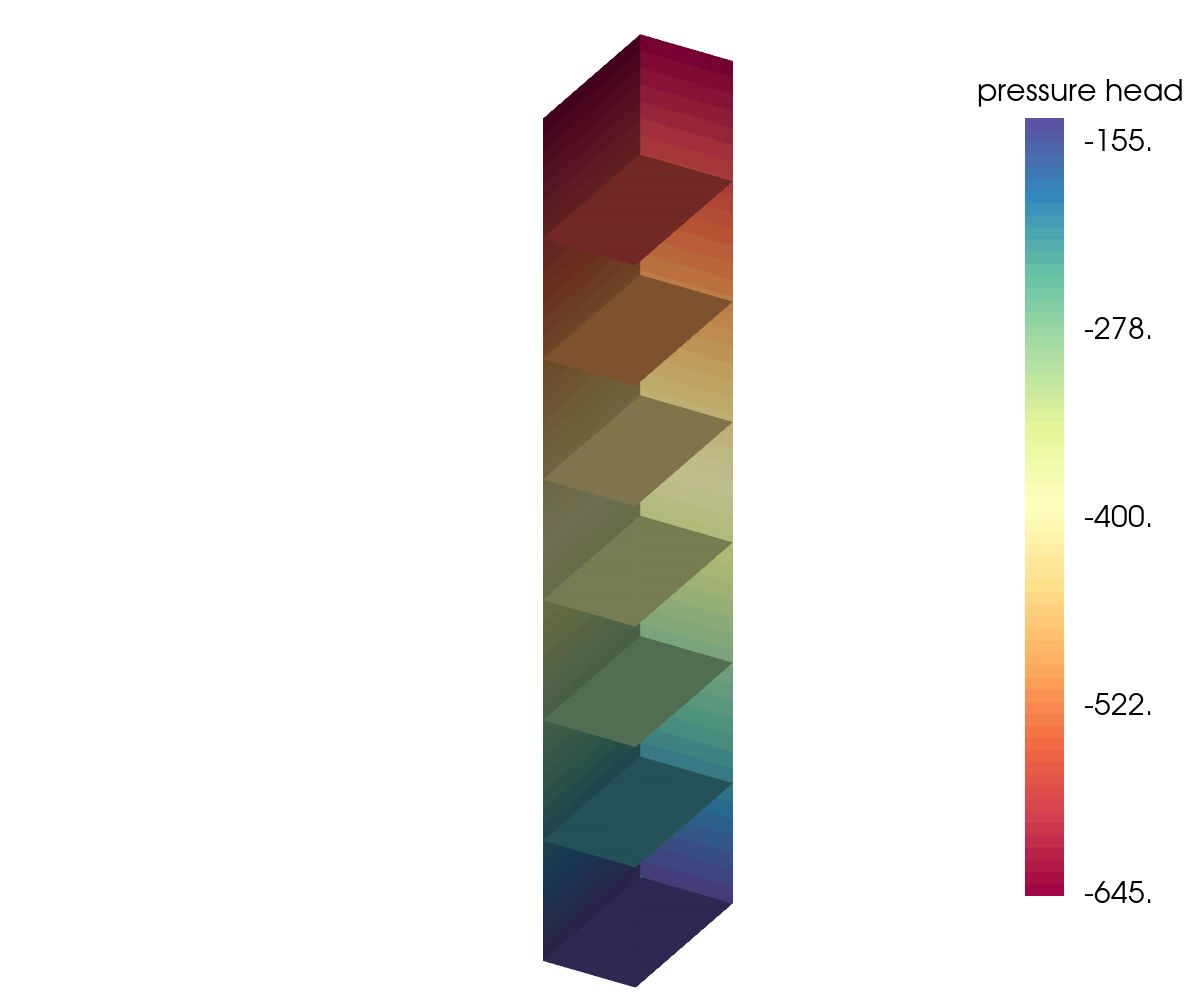

In [5]:

def visualize_soil(min_b, max_b, cell_number):
    loam = [0.08, 0.43, 0.04, 1.6, 50]
    s = RichardsWrapper(RichardsSPnum()) 
    s.initialize()     
    s.createGrid( min_b, max_b, cell_number)      
    s.setHomogeneousIC(-400., equilibrium = True)  # cm pressure head   
    s.setVGParameters([loam])
    s.setTopBC("noFlux")  
    s.setBotBC("noFlux")
    s.initializeProblem()      
    vp.plot_soil(s, "pressure head", min_b, max_b, cell_number, interactiveImage = False)

min_b = [-50., -5., -500.] # size [cm]  
max_b = [50., 5., 0.] # size [cm]  
cell_number = [5, 5, 5] # resolution
visualize_soil(min_b, max_b, cell_number)

max_b = [50., 50., 0.] # size [cm]  
cell_number = [50, 50, 50] # resolution
visualize_soil(min_b, max_b, cell_number)

max_b = [50., 50., 0.] # size [cm]  
cell_number = [1, 1, 50] # resolution <= 1D
visualize_soil(min_b, max_b, cell_number)

### Time step

Change in time step dt will lead to ? (what do we want to show here)

Computed bounding box tree with 299 nodes for 150 grid entities in 4.5543e-05 seconds.
Computed bounding box tree with 299 nodes for 150 grid entities in 3.0231e-05 seconds.
Computed bounding box tree with 299 nodes for 150 grid entities in 3.6269e-05 seconds.
Computed bounding box tree with 299 nodes for 150 grid entities in 2.692e-05 seconds.


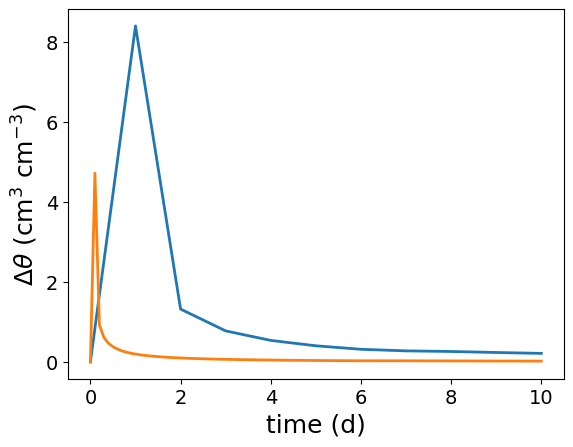

In [6]:

def run_simulation(sim_time, dt):
    min_b = [-1., -1., -150.] # size [cm]  
    max_b = [0., 0., 0.] # size [cm]  
    cell_number = [1, 1, 150] # resolution
    loam = [0.08, 0.43, 0.04, 1.6, 50]
    top_boundary_condition = "atmospheric"  ; atmospheric_value = [[0., 0.1, 0.1, 0.3, 1.e6], [10., 10., -0.1, -0.1, 0.]] # [day] and [cm/day]
    bot_boundary_condition = "constantPressure"; bot_value = 0.; top_value = 0. # [cm]
    s = RichardsWrapper(RichardsSPnum()) 
    s.initialize()     
    s.createGrid( min_b, max_b, cell_number)      
    s.setHomogeneousIC(-400., equilibrium = True)  # cm pressure head   
    s.setVGParameters([loam])    
    s.setTopBC(top_boundary_condition, top_value, atmospheric_value)  
    s.setBotBC(bot_boundary_condition, bot_value)
    s.initializeProblem()   

    x_, y_ = [0], [0]
    N = int(np.ceil(sim_time/dt))
    theta_i = s.getWaterContent() 
    for i in range(N):
        s.solve(dt) 
        theta_j = s.getWaterContent() 
        x_.append(dt * (i + 1))
        y_.append((theta_j.sum() - theta_i.sum())/dt)
        theta_i = theta_j.copy()

    plt.plot(x_, y_, linewidth = 2, label = 'dt = '+str(dt))
    plt.ylabel(r'$d\theta/dt$ (cm$^3$ cm$^{-3}$ d${-1}$)', fontsize = 18)
    plt.xlabel('time (d)', fontsize = 18)
    plt.xticks(fontsize = 14); plt.yticks(fontsize = 14)


plt.figure()
run_simulation(10., 1.)
run_simulation(10., 0.1)
plt.legend()
plt.show()

### The Van Genuchten Model

The constitutive equations are described the Van Genuchten model, giving the soil retention curve, hydraulic conductivities or matrix flux potentials. The following script show example parametrisations of various soil types. 

theta_R 0.045 theta_S 0.43 alpha 0.15 n 3 m 0.6666666666666667 Ksat 1000


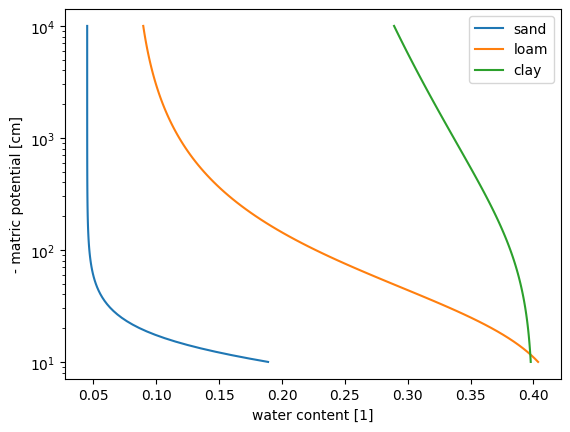

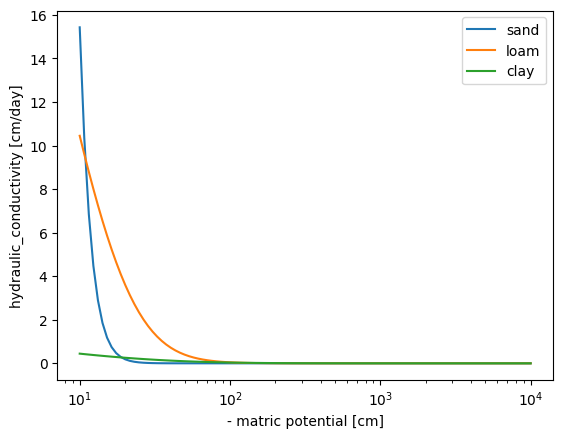

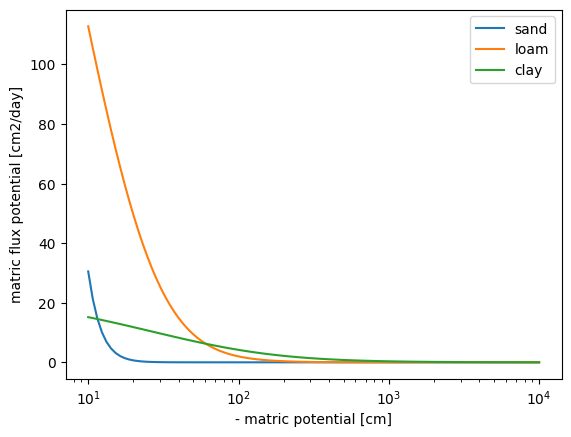

In [7]:
# Define van Genuchten parameters for sand, loam and clay  
# theta_r (-), theta_s (-), alpha (1/cm), n (-), Ks (cm d-1)
sand =  vg.Parameters([0.045, 0.43, 0.15, 3, 1000])
loam =  vg.Parameters([0.08, 0.43, 0.04, 1.6, 50])
clay =  vg.Parameters([0.1, 0.4, 0.01, 1.1, 10])

print("theta_R", sand.theta_R, "theta_S",sand.theta_S, "alpha", sand.alpha,"n",sand.n, 'm',sand.m,'Ksat', sand.Ksat)

vg.plot_retention_curve(sand, label_ = "sand")
vg.plot_retention_curve(loam, label_ = "loam")
vg.plot_retention_curve(clay, label_ = "clay")
plt.legend()
plt.show()
vg.plot_hydraulic_conductivity(sand, label_ = "sand")
vg.plot_hydraulic_conductivity(loam, label_ = "loam")
vg.plot_hydraulic_conductivity(clay, label_ = "clay")
plt.legend()
plt.show()
# ability of soil to transmit water under a given matric potential
vg.plot_matric_flux_potential(sand, label_ = "sand")
vg.plot_matric_flux_potential(loam, label_ = "loam")
vg.plot_matric_flux_potential(clay, label_ = "clay")
plt.legend()

Therefore, the retention curve relates matric potential and water content and vice versa: 

In [8]:
def pressure_head(theta, sp):
    """ returns pressure head at a given volumetric water content according to the van genuchten model 
        similar to vg.pressure_head(theta, sp)
    """
    assert theta > sp.theta_R
    assert theta <= sp.theta_S
    return -pow(pow((sp.theta_S - sp.theta_R) / (theta - sp.theta_R), (1. / sp.m)) - 1., 1. / sp.n) / sp.alpha

def theta(h, sp):
    """returns volumetric water content at a given pressure head according to the van Genuchten model"""
    return sp.theta_R + (sp.theta_S - sp.theta_R) / pow(1. + pow(sp.alpha * abs(h), sp.n), sp.m)
    

In [9]:
wilting_point = -15000 # cm
field_capacity = -100
####
#
# PAW = 
#
####

In [10]:
print(vg.effective_saturation(-500, loam))
print(vg.hydraulic_conductivity(-500, loam))

0.16521066502868686
0.00019401073323171826


### Multi-layered soil

In layered soils (i.e. contrasting parametrisations of the Van Genuchten model), the same matric potential will lead to different values for the water content, leading to jumps in water content across the profile.

Computed bounding box tree with 299 nodes for 150 grid entities in 5.1866e-05 seconds.
Computed bounding box tree with 299 nodes for 150 grid entities in 3.0742e-05 seconds.


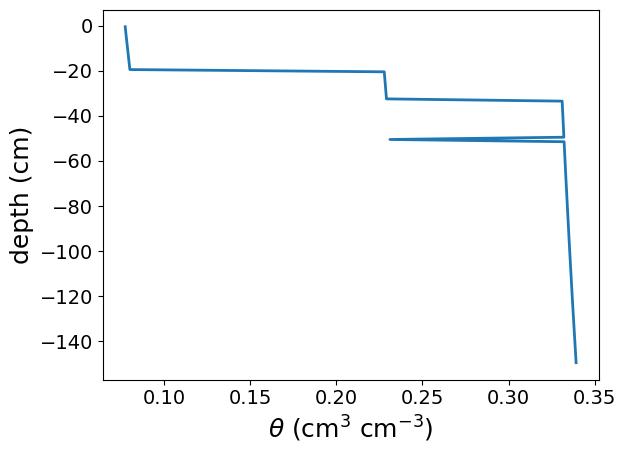

In [11]:
def visualize_soil(soil, layers_ID, layers_pos):
    min_b = [-1., -1., -150.] # size [cm]  
    max_b = [0., 0., 0.] # size [cm]  
    cell_number = [1, 1, 150] # resolution
    s = RichardsWrapper(RichardsSPnum()) 
    s.initialize()     
    s.createGrid( min_b, max_b, cell_number)      
    s.setHomogeneousIC(-400., equilibrium = True)  # cm pressure head   
    s.setVGParameters(soil)
    s.setTopBC("noFlux")  
    s.setBotBC("noFlux")
    # define soil layers
    s.setLayersZ(layers_ID, layers_pos)

    s.initializeProblem()      
    
    s.solve(1/24/3600)
    points = s.getDofCoordinates()
    theta = s.getWaterContent() 
    
    plt.figure(0)
    plt.plot(theta, points[:, 2], linewidth = 2)
    plt.xlabel(r'$\theta$ (cm$^3$ cm$^{-3}$)', fontsize = 18)
    plt.ylabel('depth (cm)', fontsize = 18)
    plt.xticks(fontsize = 14); plt.yticks(fontsize = 14)
    plt.show()  

# Define Mualem van Genuchten parameters for Selhausen soil profile according to Bauer et al. (2011, table 3, \url{https://doi.org/10.1007/s10533-011-9583-1}) |\label{l61ies:genuchten_a}|
# theta_r (-), theta_s (-), alpha (1/cm), n (-), Ks (cm d-1)
sand =  [0.045, 0.43, 0.15, 3, 1000]

l1 = [0.008, 0.389, 0.012, 1.97, 91.68]  # 0-20 cm 
l2 = [0.008, 0.389, 0.023, 1.23, 63.36]  # 20-33 cm
l3 = [0.008, 0.389, 0.01, 1.1, 10]  # 33-57 cm
l4 = [0.008, 0.389, 0.01, 1.1, 10]  # 57-120 cm
soil = [l1, l2, l3, l4] # Combine the hydraulic conductivity vectors from all soil layers to define soil type for simulation  

layers_ID = [4, 4, 3, 3, 2, 2, 1, 1]  
layers_pos = [-120., -57., -57., -33., -33, -20, -20, 0] 

visualize_soil(soil, layers_ID, layers_pos)

### Boundary conditions
1. Neumann boundary conditions (flux [cm/day], volume per surface per day)
2. Dirichlet boundary conditions (matric potential [cm])

Computed bounding box tree with 299 nodes for 150 grid entities in 5.3191e-05 seconds.
Computed bounding box tree with 299 nodes for 150 grid entities in 2.9404e-05 seconds.


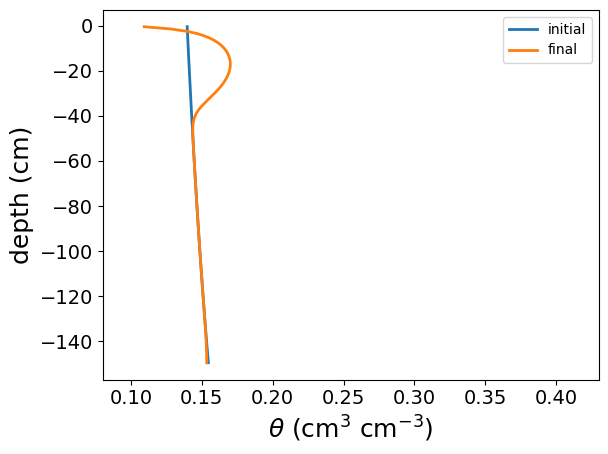

In [12]:

def run_simulation(top_boundary_condition, bot_boundary_condition, top_value, atmospheric_value, bot_value, initial_pressure, at_equilibrium):
    min_b = [-1., -1., -150.] # size [cm]  
    max_b = [0., 0., 0.] # size [cm]  
    cell_number = [1, 1, 150] # resolution
    loam = [0.08, 0.43, 0.04, 1.6, 50]
    s = RichardsWrapper(RichardsSPnum()) 
    s.initialize()     
    s.createGrid( min_b, max_b, cell_number)      
    s.setHomogeneousIC(initial_pressure, equilibrium = at_equilibrium)  # cm pressure head   
    s.setVGParameters([loam])
    ###
    s.setTopBC(top_boundary_condition, top_value, atmospheric_value)  
    s.setBotBC(bot_boundary_condition, bot_value)
    ###
    s.initializeProblem()   
    points0 = s.getDofCoordinates()
    theta0 = s.getWaterContent()
    s.solve(10.) 
    points = s.getDofCoordinates()
    theta = s.getWaterContent() 
    
    plt.figure(0)
    plt.plot(theta0, points0[:, 2], linewidth = 2, label = "initial")
    plt.plot(theta, points[:, 2], linewidth = 2, label = "final")
    plt.xlabel(r'$\theta$ (cm$^3$ cm$^{-3}$)', fontsize = 18)
    plt.ylabel('depth (cm)', fontsize = 18)
    plt.xticks(fontsize = 14); plt.yticks(fontsize = 14)
    plt.xlim(loam[0], loam[1]) 
    plt.legend()
    plt.show()  

atmospheric_value = []; top_value = 0.; bot_value = 0. # default

# Neumann options: "noFlux", "constantFlux", bottom BC: "freeDrainage" advanced options: "atmospheric" 
# Dirichlet options: "constantPressure" 

# Neumann BC. flux is lowered if it cannot be respected
# top_boundary_condition = "noFlux"   
# top_boundary_condition = "constantFlux"; top_value = -1. # ; top_value = 1. #[cm/day]
bot_boundary_condition = "freeDrainage"
# bot_boundary_condition = "noFlux"   
# bot_boundary_condition = "constantFlux"; bot_value = 1. # [cm/day]

# Neumann BC from environmental variables
top_boundary_condition = "atmospheric"  ; atmospheric_value = [[0., 0.1, 0.1, 0.3, 1.e6], [10., 10., -0.1, -0.1, 0.]] # [day] and [cm/day]

# Dirichlet BC.
# top_boundary_condition = "constantPressure"; top_value = -1500. # [cm]
# bot_boundary_condition = "constantPressure"; bot_value = 0. # [cm]

initial_pressure = -400
at_equilibrium = True

run_simulation(top_boundary_condition, bot_boundary_condition, top_value, atmospheric_value, bot_value, initial_pressure, at_equilibrium)


### Select outputs
1. Specific time points
2. Specific areas
3. Specific variables

Computed bounding box tree with 7499 nodes for 3750 grid entities in 0.00133594 seconds.
Computed bounding box tree with 7499 nodes for 3750 grid entities in 0.00101536 seconds.
measurement_point 3498


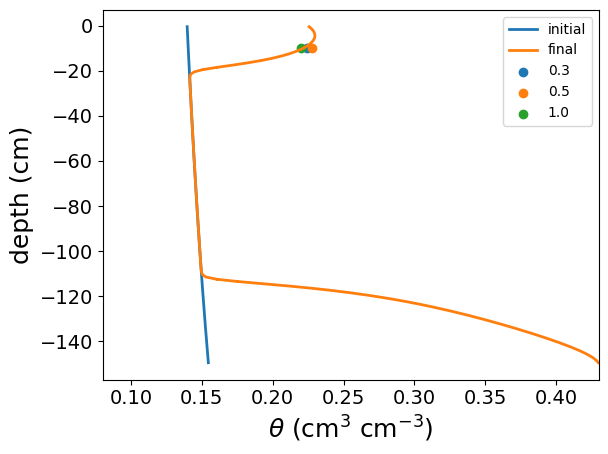

In [13]:

def run_simulation(meas_time, meas_coord):
    min_b = [-5., -5., -150.] # size [cm]  
    max_b = [0., 0., 0.] # size [cm]  
    cell_number = [5, 5, 150] # resolution
    loam = [0.08, 0.43, 0.04, 1.6, 50]
    s = RichardsWrapper(RichardsSPnum()) 
    s.initialize()     
    s.createGrid( min_b, max_b, cell_number)      
    s.setHomogeneousIC(-400., equilibrium = True)  # cm pressure head   
    s.setVGParameters([loam])
    atmospheric_value = []; top_value = 0.; bot_value = 0. # default
    top_boundary_condition = "atmospheric"  ; atmospheric_value = [[0., 0.1, 0.1, 0.3, 1.e6], [10., 10., -0.1, -0.1, 0.]] # [day] and [cm/day]
    bot_boundary_condition = "constantPressure"; bot_value = 0. # [cm]
    s.setTopBC(top_boundary_condition, top_value, atmospheric_value)  
    s.setBotBC(bot_boundary_condition, bot_value)    
    s.initializeProblem()   

    ##
    measurement_point = s.pick(meas_coord)
    print("measurement_point", measurement_point)
    ##
    
    x_, y_ = [], []
    time = 0.
    points0 = s.getDofCoordinates()
    theta0 = s.getWaterContent()
    
    for dt in np.diff(meas_time):
        s.solve(dt) #10.) 
        time += dt
        x_.append(time)
        output = s.getWaterContent()[measurement_point] # s.getSolutionHead()[measurement_point]
        y_.append(output)
        
    pointsf = s.getDofCoordinates()
    thetaf = s.getWaterContent() 
    
    plt.figure()
    plt.plot(theta0, points0[:, 2], linewidth = 2, label = "initial")
    plt.plot(thetaf, pointsf[:, 2], linewidth = 2, label = "final")
    for i in range(len(x_)):
        plt.scatter( y_[i], meas_coord[2],label=x_[i])            
    plt.xlabel(r'$\theta$ (cm$^3$ cm$^{-3}$)', fontsize = 18)
    plt.ylabel('depth (cm)', fontsize = 18)
    plt.xticks(fontsize = 14); plt.yticks(fontsize = 14)
    plt.xlim(loam[0], loam[1]) 
    plt.legend()
    plt.show()  

meas_time = [0., 0.3, 0.5, 1.] # days
meas_coord = [-1., -1., -10.] # x, y, z coordinate with regards to the upper-left corner of the soil domaine
run_simulation(meas_time, meas_coord)

## Simulations: 

1. Infiltration into an initially dry soil

2. Evaporation from an initially moist soil 

3. Infiltration and evaporation from a multi-layered soil

4. Water uptake by a single root in 1D axisymmetric geometry

Computed bounding box tree with 199 nodes for 100 grid entities in 4.539e-05 seconds.
Computed bounding box tree with 199 nodes for 100 grid entities in 2.2056e-05 seconds.


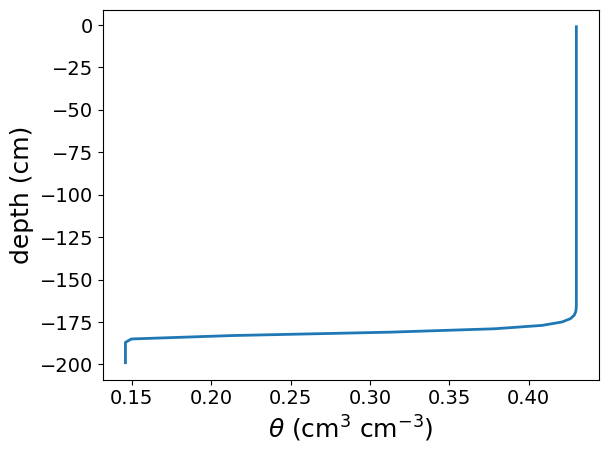

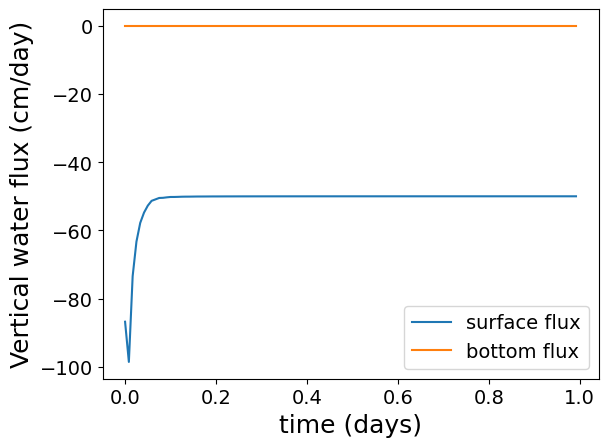

In [14]:
# Define van Genuchten parameters for sand, loam and clay  
# theta_r (-), theta_s (-), alpha (1/cm), n (-), Ks (cm d-1)
sand = [0.045, 0.43, 0.15, 3, 1000]
loam = [0.08, 0.43, 0.04, 1.6, 50]
# clay = [0.1, 0.4, 0.01, 1.1, 10]
soil = loam  # Select soil type for simulation  
# simulation time, days
sim_time = 1;  # |\label{l61i:simtime}|
dt = 720 / (24 * 3600)  # time step [days]   

# Solve the Richards equation using the Python wrapper of dumux-rosi
s = RichardsWrapper(RichardsSPnum()) 
s.initialize() 
s.setTopBC("atmospheric", 0.5, [[-1., 1.e10], [100., 100.]])  #  [cm/day] atmospheric is with surface run-off   
s.setBotBC("freeDrainage") 
N = 100
s.createGrid([-5., -5., -200.], [5., 5., 0.], [1, 1, N])  # [cm] N  
s.setHomogeneousIC(-400.)  # cm pressure head   
s.setVGParameters([soil])
s.initializeProblem()  
s.setCriticalPressure(-15000)  
s.ddt = 1.e-5  # initial dumux time step [days]  

top_ind = s.pick([0., 0., -0.5])  
bot_ind = s.pick([0., 0., -199.5]) 
top_new, bot_new, soil_times = [], [], []  

N = int(np.ceil(sim_time / dt)) 
for i in range(0, N):
    t = i * dt  # current simulation time   
    soil_times.append(t)  
    s.solve(dt)  
    velocities = s.getVelocities_()  
    top_new.append(velocities[top_ind])
    bot_new.append(velocities[bot_ind])  

top_new = np.array(top_new)  
bot_new = np.array(bot_new)
soil_times = np.array(soil_times)  

# Extract and plot numerical solution  
points = s.getDofCoordinates()
theta = s.getWaterContent()
plt.figure(0)
plt.plot(theta, points[:, 2], linewidth = 2)
plt.xlabel(r'$\theta$ (cm$^3$ cm$^{-3}$)', fontsize = 18)
plt.ylabel('depth (cm)', fontsize = 18)
plt.xticks(fontsize = 14); plt.yticks(fontsize = 14)
plt.show()  

plt.figure(1)  
plt.plot(soil_times, top_new[:, 2], label = "surface flux")
plt.plot(soil_times, bot_new[:, 2], label = "bottom flux")
plt.xlabel('time (days)', fontsize = 18)
plt.ylabel('Vertical water flux (cm/day)', fontsize = 18)
plt.xticks(fontsize = 14); plt.yticks(fontsize = 14)
plt.legend(fontsize = 14)
plt.show()  


### Evaporation from an initially moist soil 

This example reproduces the evaporation example M2.2 from Schnepf et al. (2023). Water evaporated from the surface of an initially moist soil. Only the vertical water movement is considered. Atmospheric boundary conditions are set at the upper boundary and a free drainage boundary condition is set at the lower boundary. There is an analytical solution for this simple example, which can optionally be plotted for comparison.

Computed bounding box tree with 199 nodes for 100 grid entities in 5.6314e-05 seconds.
Computed bounding box tree with 199 nodes for 100 grid entities in 2.4392e-05 seconds.
initial water volume 1791.9056501866478


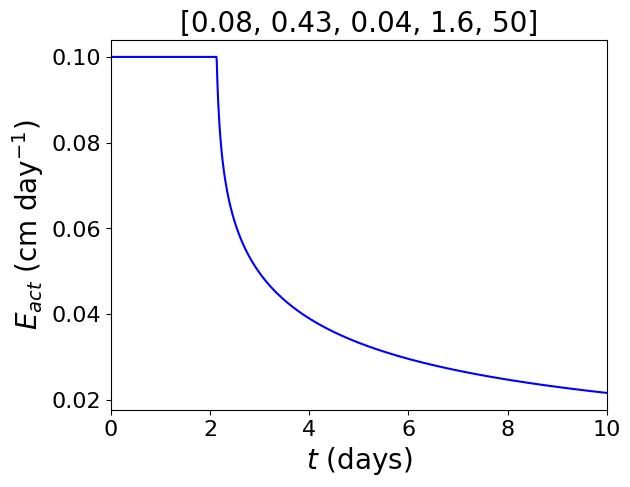

In [15]:
soil = loam  # Select soil type for simulation  
sim_time = 10;  
N = 2000
dt = sim_time / N  # time step [days]  
ic = -200  
evap = -0.1  # [cm/day] Potential transpiration

s = RichardsWrapper(RichardsSP())  
s.initialize()  
s.setTopBC("atmospheric", 0.5, [[0., 1.e10], [evap, evap]])  #  [cm/day]    
# s.setTopBC("flux", evap)  #  [cm/day]
# s.setTopBC("constantPressure", -10000)
s.setBotBC("freeDrainage")  # BC freeDrainage  
NZ = 100 # 1399
s.createGrid([-5., -5., -100.], [5., 5., 0.], [1, 1, NZ])  # [cm]  
# vols = (100. / NZ) * np.ones((NZ,)) * 100.  # cm3
s.setVGParameters([soil])  
s.setHomogeneousIC(ic)  # cm pressure head  
# s.setParameter("Problem.EnableGravity", "false")
s.initializeProblem()  
s.setCriticalPressure(-10000)  
s.setRegularisation(1.e-6, 0.)  
idx_top = s.pickCell([0.0, 0.0, 0.0])  # index to watch surface flux  
initial_water = s.getWaterVolume() 
print("initial water volume", initial_water)
s.ddt = 1.e-5  # initial Dumux time step [days] 
maxDt = 1.  # maximal Dumux time step [days]  

x_, y_ = [], []
for i in range(0, N):  
    s.solve(dt, maxDt)  
    f = s.getNeumann(idx_top)  # f = s.getSolutionHeadAt(idx_top)   
    #   current_water = s.getWaterVolume()
    #   f = (initial_water - current_water) / dt / 1.e2
    #   print(current_water, f)
    #   initial_water = current_water
    x_.append(s.simTime)
    y_.append(f)  

# Extract and plot numerical solution
plt.plot(x_, y_, 'b') 
plt.ylabel('$E_{act}$ (cm day$^{-1}$)', fontsize = 20)
plt.xlim(0, 10)
plt.title(soil, fontsize = 20)
plt.xlabel('$t$ (days)', fontsize = 20)
plt.ylabel('$E_{act}$ (cm day$^{-1}$)', fontsize = 20)
plt.tick_params(axis = 'both', which = 'major', labelsize = 16)
plt.show()  


### Infiltration and evaporation from a multi-layered soil

This example builds on the infiltration and evaporation problem M2.1 and M2.2 from Schnepf et al. (2023) and extends the simulation to a multi-layered soil profile at the Field Minirhizotron Facilities Selhausen (\url{https://www.fz-juelich.de/en/ibg/ibg-3/research-groups/modelling-terrestrial-systems/soil-root-systems-and-rhizosphere-processes/field-minirhizotron-facilities}).
The hydraulic properties of the soil profile are taken from Bauer et al. (2011, table 3, \url{https://doi.org/10.1007/s10533-011-9583-1}).
The Richards equations is solved to simulate water infiltration over 1 day into an initially dry soil followed by evaporation over 2 days. Only the vertical water movement is considered. A Neumann boundary condition is set at the upper boundary and a free drainage boundary condition is set at the lower boundary.

Computed bounding box tree with 59 nodes for 30 grid entities in 3.4431e-05 seconds.
Computed bounding box tree with 59 nodes for 30 grid entities in 1.3631e-05 seconds.
***** external time step 0.008333333333333333  d, simulation time 0.008333333333333333 d, internal time step 0.0020207345920138873 d
***** external time step 0.008333333333333333  d, simulation time 0.09166666666666666 d, internal time step 0.0017722561507270266 d
***** external time step 0.008333333333333333  d, simulation time 0.175 d, internal time step 0.0012702238864568944 d
***** external time step 0.008333333333333333  d, simulation time 0.25833333333333336 d, internal time step 0.0009007035062119394 d
***** external time step 0.008333333333333333  d, simulation time 0.3416666666666667 d, internal time step 0.0009007035062119394 d
***** external time step 0.008333333333333333  d, simulation time 0.425 d, internal time step 0.0009007035062119394 d
***** external time step 0.008333333333333333  d, simulation time 

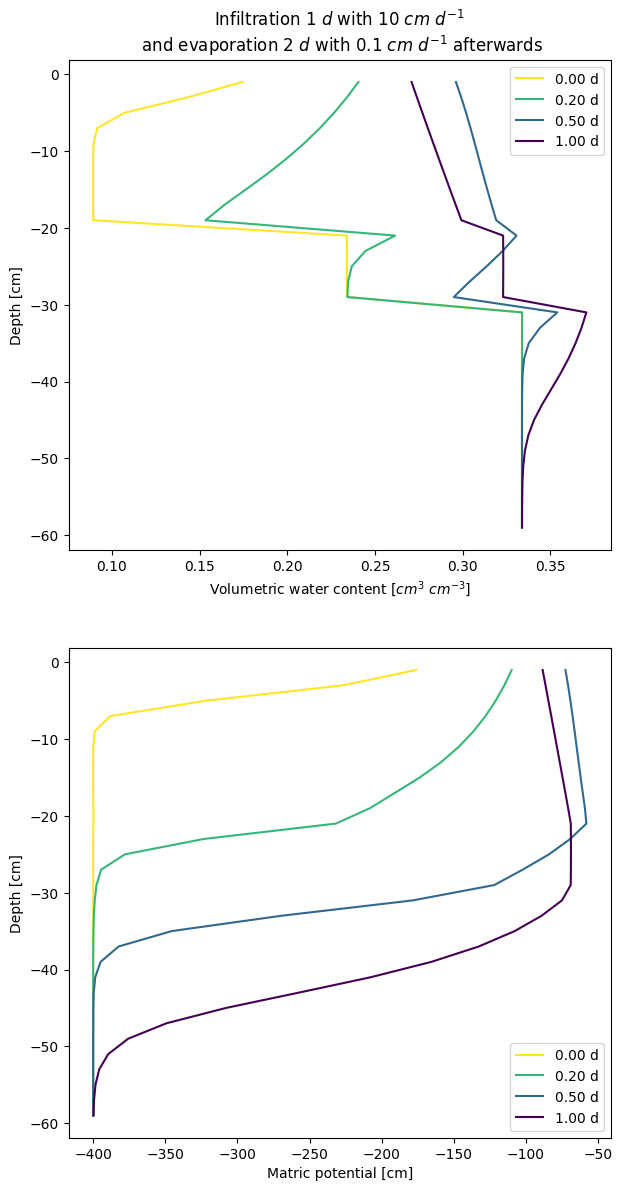

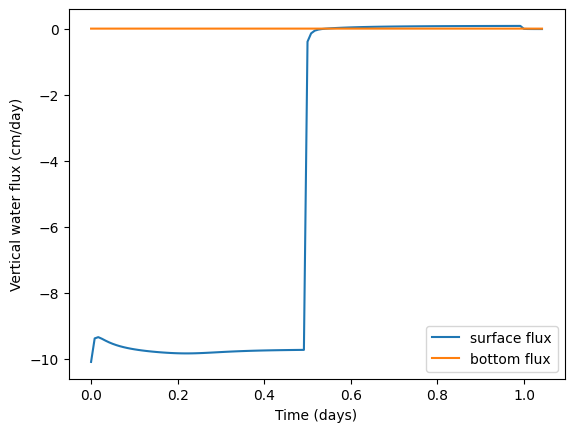

In [5]:
# Define Mualem van Genuchten parameters for Selhausen soil profile according to Bauer et al. (2011, table 3, \url{https://doi.org/10.1007/s10533-011-9583-1}) |\label{l61ies:genuchten_a}|
# theta_r (-), theta_s (-), alpha (1/cm), n (-), Ks (cm d-1)
l1 = [0.008, 0.389, 0.012, 1.97, 91.68]  # 0-20 cm 
l2 = [0.008, 0.389, 0.023, 1.23, 63.36]  # 20-30 cm
l3 = [0.008, 0.389, 0.01, 1.1, 10]  # 30-60 cm

soil = [l1, l2, l3] # Combine the hydraulic conductivity vectors from all soil layers to define soil type for simulation  
sim_time = 1.05  # 3.05
dt = 720 / (24 * 3600)  # time step [days] # 0.05

# Solve the Richards equation using the Python wrapper of dumux-rosi
s = RichardsWrapper(RichardsSPnum())  
s.initialize()  #
s.setTopBC("atmospheric", 0.5, [[ 0., 0.5,  0.5,   1., 1., 1.e6], 
                                [10., 10., -0.1, -0.1, 0., 0.]])  #  [cm/day] atmospheric is with surface run-off  
s.setBotBC("freeDrainage") 
N = 30   # use a fine grid resolution of 1 mm per grid point in z direction 
s.createGrid([-5., -5., -60.], [5., 5., 0.], [1, 1, N])  # [cm] N   
# define soil layers
layers_ID = [3, 3, 2, 2, 1, 1]  
layers_pos = [-60.,-30., -30, -20, -20, 0] 
s.setLayersZ(layers_ID, layers_pos)
s.setHomogeneousIC(-400.)  # cm pressure head   
s.setVGParameters(soil) 
s.initializeProblem()  
s.setCriticalPressure(-15000)  
s.ddt = 1.e-5  # initial dumux time step [days]

top_ind = s.pick([0., 0., -0.5])
bot_ind = s.pick([0., 0., -59.5])  
top_new, bot_new, soil_times = [], [], []

N = int(np.ceil(sim_time / dt))  
z_, x_, h_ = [], [], []  # initialize solution vectors
import timeit; wall_iteration = timeit.default_timer()
for i in range(0, N):
    s.ddt = 1.e-5  # initial dumux time step [days]
    t = i * dt  # current simulation time
    soil_times.append(t)
    s.solve(dt)
    if i % 10 == 0:
        print("***** external time step", dt, " d, simulation time", s.simTime, "d, internal time step", s.ddt, "d")

    velocities = s.getVelocities_()
    top_new.append(velocities[top_ind])
    bot_new.append(velocities[bot_ind])

    points = s.getDofCoordinates()  # coordinates
    theta = s.getWaterContent()  # volumetric water content
    h = s.getSolutionHead()  # matric potential [cm]
    z_.append(points[:, 2])
    x_.append(theta)
    h_.append(h)
wall_iteration = timeit.default_timer() - wall_iteration
top_new = np.array(top_new)
bot_new = np.array(bot_new)
soil_times = np.array(soil_times)

sel_idx = np.searchsorted(soil_times, [0., 0.2, 0.5, 1.]) #, 1.2, 2., 3.]) # define output times

# Plot solutions 
fig1, axs = plt.subplots(2, 1, figsize = (7, 14))
cmap = plt.cm.viridis  # or 'plasma', 'cividis', 'Blues'
cols = cmap(np.linspace(0, 1, len(sel_idx)))
cols = cols[::-1]
for ii, i in enumerate(sel_idx):
    axs[0].plot(x_[i], z_[i], color = cols[ii], label = f'{soil_times[i]:.2f} d')
    axs[1].plot(h_[i], z_[i], color = cols[ii], label = f'{soil_times[i]:.2f} d')

axs[0].set_title("Infiltration 1 $d$ with 10 $cm$ $d^{-1}$ \n and evaporation 2 $d$ with 0.1 $cm$ $d^{-1}$ afterwards")
axs[0].set_xlabel('Volumetric water content [$cm^{3}$ $cm^{-3}$]')
axs[0].set_ylabel('Depth [cm]')
axs[1].set_xlabel('Matric potential [cm]')
axs[1].set_ylabel('Depth [cm]')
axs[0].legend(loc = "best")
axs[1].legend(loc = "best")

plt.show()

plt.figure(1)
plt.plot(soil_times, top_new[:, 2], label = "surface flux")
plt.plot(soil_times, bot_new[:, 2], label = "bottom flux")
plt.xlabel('Time (days)')
plt.ylabel('Vertical water flux (cm/day)')
plt.legend()
plt.show()


### Water uptake by a single root in 1D axisymmetric geometry



area per cell [cm2] [[0.0014192 ]
 [0.00302198]
 [0.00643488]
 [0.01370219]
 [0.0291769 ]
 [0.06212813]
 [0.13229317]
 [0.28169983]
 [0.59984045]]
Distance from root surface [cm] [[0.02459233]
 [0.03588593]
 [0.05236593]
 [0.07641408]
 [0.11150593]
 [0.16271312]
 [0.23743632]
 [0.34647486]
 [0.50558748]]

domain water volume 2.4618629269006114 cm3/cm  =  0.0024618629269006114 l/cm
water content to water volume 2.4618629269006114 cm3/cm
 -- Using the default temperature of 293.15 in the entire domain. Overload temperatureAtPos() in your spatial params class to define a custom temperature field.Or provide the preferred domain temperature via the SpatialParams.Temperature parameter.
domain water volume 1.0964707722756415 cm3/cm  =  0.0010964707722756414 l/cm
change in water volume -1.3653921546249699 cm3/cm =  -0.00136539215462497 l/cm


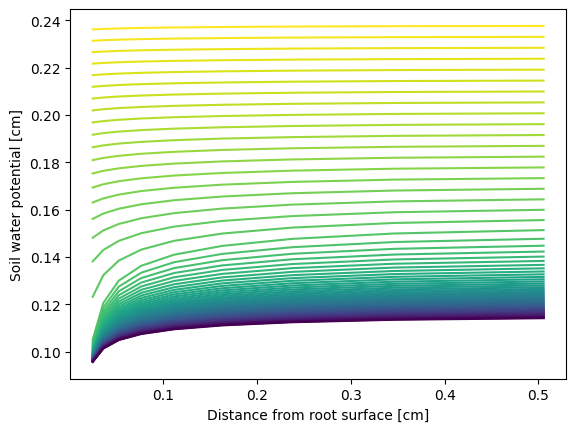

In [6]:
def sinusoidal(t):
    """ sinusoidal function (used for transpiration) (integral over one day is 1)"""
    return np.sin(2. * np.pi * np.array(t) - 0.5 * np.pi) + 1.


def plot_profile(cc, h, depth = -100.):
    """ shows soil matric potential profile over time"""
    fig, ax1 = plt.subplots()
    n = len(h) // 1
    cmap = plt.cm.viridis  # or 'plasma', 'cividis', 'Blues'
    cols = cmap(np.linspace(0, 1, n))
    cols = cols[::-1]
    for i in range(0, n):
        ax1.plot(cc, h[i * 1], color = cols[i])
    ax1.set_ylabel("Soil water potential [cm]")
    ax1.set_xlabel("Distance from root surface [cm]")


""" Soil """
s = RichardsFlatWrapper(RichardsCylFoam())  # water & single solute
logbase = 0.5
NC = 10  # [1] spatial resolution (1D model)
a_in = 0.02  # cm
a_out = 0.6  # cm
points = np.logspace(np.log(a_in) / np.log(logbase), np.log(a_out) / np.log(logbase), NC, base = logbase)
soil = [0.078, 0.43, 0.036, 1.56, 24.96]  # hydrus loam
s.initialize()
s.createGrid1d(points)
s.setVGParameters([soil])

""" Inital conditions """
s.setHomogeneousIC(-100.)  # [cm] homogeneous pressure head

""" Boundary conditions """
RS_Uptake_Wmax = 1.  # [cm/day]
s.setOuterBC("fluxCyl", 0.)  #  [cm/day] Neumann boundary condition
s.setInnerBC("fluxCyl", 0.)

""" Initialze problem """  # |\label{l63:init_start}|
s.setParameter("Newton.EnableAbsoluteResidualCriterion", "True")
s.setParameter("Newton.MaxAbsoluteResidual", "1.e-10")
s.setParameter("Newton.SatisfyResidualAndShiftCriterion", "True")
s.setParameter("Newton.EnableChop", "True")
s.initializeProblem()
wilting_point = -10000
s.setCriticalPressure(wilting_point)
s.ddt = 1e-4  # [day] initial Dumux time step

""" Simulation loop """
simtime = 3
dt = 3600. / (24.*3600)
cc = np.array(s.getCellCenters())  # [cm]
points = np.array(s.getPoints())  # [cm] cell faces
area = np.pi * (points[1:] ** 2 - points[:-1] ** 2)  # [cm2] area of each cell
print("area per cell [cm2]", area)
print("Distance from root surface [cm]", cc)
theta = np.array(s.getWaterContent())
volume0 = np.sum(np.multiply(theta , area))
print("\ndomain water volume", volume0, "cm3/cm  = ", volume0 / 1000, "l/cm")
print("water content to water volume", volume0 , "cm3/cm")

N = int(np.ceil(simtime / dt))
h, theta = [], []  # results

for i in range(0, N):
    t = i * dt  # current simulation time
    #print(t, "days")

    s.setInnerBC("fluxCyl", -RS_Uptake_Wmax)  # [cm/day]; * sinusoidal(t)
    s.solve(dt)
    h.append(s.getSolutionHead())  # [cm]
    theta.append(s.getWaterContent())  # [1]

volumef = np.sum(np.multiply(theta[-1] , area))  # |\label{l63:vol}|
print("domain water volume", volumef, "cm3/cm  = ", volumef / 1000., "l/cm")  # |\label{l63:results}|
print("change in water volume", volumef - volume0, "cm3/cm = ", 1.e-3 * (volumef - volume0), "l/cm")

plot_profile(cc, theta)
plt.show()
